# 利用Python对链家网北京主城区二手房进行数据分析
* 本文主要讲述如何通过pandas对爬虫下来的链家数据进行相应的二手房数据分析，主要分析内容包括各个行政区，各个小区的房源信息情况。
* 数据来源 https://github.com/XuefengHuang/lianjia-scrawler 该repo提供了python程序进行链家网爬虫，并从中提取二手房价格、面积、户型和二手房关注度等数据。
* 分析方法参考 http://www.jianshu.com/p/44f261a62c0f

## 导入链家网二手房在售房源的文件（数据更新时间2017-11-29）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import sys

stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout

plt.rcParams['font.sans-serif'] = ['SimHei']    
plt.rcParams['axes.unicode_minus'] = False

#所有在售房源信息
house=pd.read_csv('houseinfo.csv')

# 所有小区信息
community=pd.read_csv('community.csv')

# 合并小区信息和房源信息表，可以获得房源更详细的地理位置
community['community'] = community['title']
house_detail = pd.merge(house, community, on='community')

## 将数据从字符串提取出来

In [2]:
# 将字符串转换成数字
def data_adj(area_data, str):       
    if str in area_data :        
        return float(area_data[0 : area_data.find(str)])    
    else :        
        return None
# 处理房屋面积数据
house['square'] = house['square'].apply(data_adj,str = '平米')

## 删除车位信息

In [3]:
car=house[house.housetype.str.contains('车位')]
print '记录中共有车位%d个'%car.shape[0]
house.drop(car.index,inplace=True)
print '现在还剩下%d条记录'%house.shape[0]

记录中共有车位32个
现在还剩下16076条记录


## 价格最高的5个别墅

In [4]:
bieshu=house[house.housetype.str.contains('别墅')]
print '记录中共有别墅%d栋'%bieshu.shape[0]
bieshu.sort_values('totalPrice',ascending=False).head(5)

记录中共有别墅50栋


,houseID,title,link,community,years,housetype,square,direction,floor,taxtype,totalPrice,unitPrice,followInfo,validdate
8020,101102078117,香山清琴二期独栋别墅，毛坯房原始户型，花园1200平米,https://bj.lianjia.com/ershoufang/101102078117...,香山清琴,2层2007年建,独栋别墅,NaN,1002.56平米,2层2007年建,房本满五年,12500,124681,45人关注 / 共7次带看 / 2个月以前发布,2017-11-29 14:31:35
102,101100652295,千尺独栋 北入户 红顶商人金融界入住社区,https://bj.lianjia.com/ershoufang/101100652295...,龙湖颐和原著,2层2010年建,独栋别墅,NaN,1071.32平米,2层2010年建,距离4号线西苑站839米房本满五年,12000,112012,231人关注 / 共26次带看 / 一年前发布,2017-11-29 14:36:53
2729,101101641953,临湖独栋别墅 花园半亩 观景湖面和绿化 满五年有车库房主自荐,https://bj.lianjia.com/ershoufang/101101641953...,紫玉山庄,3层2000年建,独栋别墅,NaN,403.72平米,3层2000年建,房本满五年,6000,148618,108人关注 / 共16次带看 / 5个月以前发布,2017-11-28 16:42:18
3141,101101684273,银湖别墅 独栋 望京公园旁 五环里 封闭式社区,https://bj.lianjia.com/ershoufang/101101684273...,银湖别墅,3层1998年建,独栋别墅,NaN,383.59平米,3层1998年建,房本满五年,5000,130348,9人关注 / 共3次带看 / 5个月以前发布,2017-11-28 15:20:06
4112,101101796191,首排别墅 位置好 全景小区绿化和人工湖 有车库,https://bj.lianjia.com/ershoufang/101101796191...,亚运新新家园朗月园一期,1层2003年建,联排别墅,NaN,461.37平米,1层2003年建,房本满五年,3800,82364,0人关注 / 共4次带看 / 4个月以前发布,2017-11-28 15:34:28


## 删除别墅信息

In [5]:
house.drop(bieshu.index,inplace=True)
print '现在还剩下%d条记录'%house.shape[0]

现在还剩下16026条记录


## 获取总价前五的房源信息

In [6]:
house.sort_values('totalPrice',ascending=False).head(5)

,houseID,title,link,community,years,housetype,square,direction,floor,taxtype,totalPrice,unitPrice,followInfo,validdate
8571,101102105035,中关村创业大街对过 有名的公司入驻其中正规写字楼,https://bj.lianjia.com/ershoufang/101102105035...,银科大厦,低楼层(共22层)2004年建塔楼,1房间0卫,2623.28,东 南 西 北,低楼层(共22层)2004年建塔楼,距离10号线苏州街站898米房本满五年,12000,45745,1人关注 / 共0次带看 / 2个月以前发布,2017-11-29 14:07:32
11758,101102235883,中关村创业大街对过 有名的公司入驻其中正规一层底商,https://bj.lianjia.com/ershoufang/101102235883...,银科大厦,底层(共22层)2004年建塔楼,1房间0卫,1182.80,东北,底层(共22层)2004年建塔楼,距离10号线苏州街站898米房本满五年,12000,101455,0人关注 / 共0次带看 / 1个月以前发布,2017-11-29 14:07:33
2480,101101608106,西山别墅区拥有900平大花园纯独栋社区房主自荐,https://bj.lianjia.com/ershoufang/101101608106...,香山清琴,1层2007年建,7室3厅,482.16,南 北,1层2007年建,房本满五年,7000,145181,94人关注 / 共24次带看 / 6个月以前发布,2017-11-29 14:31:34
14492,101102306092,盘古大观 大平层 观景房 格局可塑性强！,https://bj.lianjia.com/ershoufang/101102306092...,盘古大观,中楼层(共22层)2007年建塔楼,3室2厅,671.35,东 南 西,中楼层(共22层)2007年建塔楼,NaN,6700,99799,16人关注 / 共0次带看 / 13天以前发布,2017-11-28 15:19:41
10154,101102178295,朝阳公园内建筑，视野好，可以俯视朝阳公园美景,https://bj.lianjia.com/ershoufang/101102178295...,霄云路8号,高楼层(共27层)2011年建塔楼,4室3厅,453.64,南 北,高楼层(共27层)2011年建塔楼,房本满两年,5500,121242,39人关注 / 共4次带看 / 1个月以前发布,2017-11-28 15:52:12


## 获取户型数量分布信息

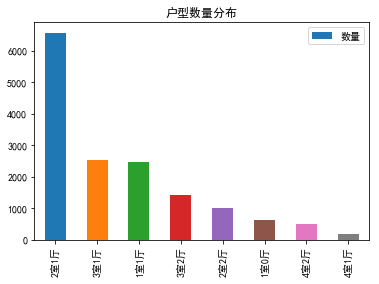

In [7]:
housetype = house['housetype'].value_counts()
housetype.head(8).plot(kind='bar',x='housetype',y='size', title='户型数量分布')
plt.legend(['数量']) 
plt.show()

## 关注人数最多5套房子

In [8]:
house['guanzhu'] = house['followInfo'].apply(data_adj,str = '人关注')
house.sort_values('guanzhu',ascending=False).head(5)

,houseID,title,link,community,years,housetype,square,direction,floor,taxtype,totalPrice,unitPrice,followInfo,validdate,guanzhu
47,101100379913,弘善家园南向开间，满两年，免增值税,https://bj.lianjia.com/ershoufang/101100379913...,弘善家园,中楼层(共28层)2009年建塔楼,1室0厅,42.64,南,中楼层(共28层)2009年建塔楼,距离10号线十里河站698米房本满两年随时看房,265,62149,1401人关注 / 共305次带看 / 一年前发布,2017-11-29 09:34:23,1401.0
2313,101101588951,四惠东 康家园 南向一居室 地铁1号线出行房主自荐,https://bj.lianjia.com/ershoufang/101101588951...,康家园,顶层(共6层)1995年建板楼,1室1厅,41.97,南,顶层(共6层)1995年建板楼,距离1号线四惠东站974米房本满五年随时看房,262,62426,1005人关注 / 共86次带看 / 6个月以前发布,2017-11-28 17:21:58,1005.0
990,101101355617,远见名苑 东南两居 满五年家庭唯一住房 诚心出售房主自荐,https://bj.lianjia.com/ershoufang/101101355617...,远见名苑,中楼层(共24层)2004年建塔楼,2室1厅,90.14,东南,中楼层(共24层)2004年建塔楼,距离7号线达官营站516米房本满五年,811,89972,979人关注 / 共50次带看 / 8个月以前发布,2017-11-29 10:09:39,979.0
2331,101101590746,荣丰二期朝南复式无遮挡全天采光房主自荐,https://bj.lianjia.com/ershoufang/101101590746...,荣丰2008,中楼层(共10层)2005年建塔楼,1室1厅,32.54,南,中楼层(共10层)2005年建塔楼,距离7号线达官营站1028米房本满五年随时看房,400,122926,972人关注 / 共369次带看 / 6个月以前发布,2017-11-29 10:08:38,972.0
915,101101327417,通州万达北苑地铁站 天时名苑 大两居可改3居,https://bj.lianjia.com/ershoufang/101101327417...,天时名苑,顶层(共9层)2009年建板塔结合,2室2厅,121.30,南 北,顶层(共9层)2009年建板塔结合,距离八通线通州北苑站602米房本满五年,645,53174,894人关注 / 共228次带看 / 8个月以前发布,2017-11-29 09:20:13,894.0


## 户型和关注人数分布

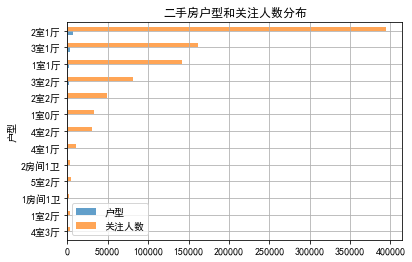

In [9]:
fig, ax1 = plt.subplots(1,1)    
type_interest_group = house['guanzhu'].groupby(house['housetype']).agg([('户型', 'count'), ('关注人数', 'sum')])    
#取户型>50的数据进行可视化
ti_sort = type_interest_group[type_interest_group['户型'] > 50].sort_values(by='户型')    
ti_sort.plot(kind='barh', alpha=0.7, grid=True, ax=ax1)    
plt.title('二手房户型和关注人数分布')    
plt.ylabel('户型') 
plt.show()

## 面积分布

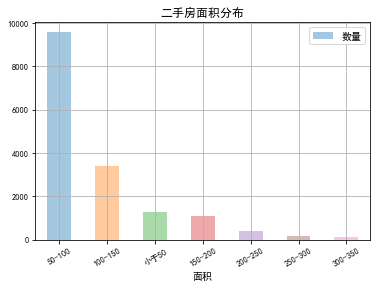

In [10]:
fig,ax2 = plt.subplots(1,1)    
area_level = [0, 50, 100, 150, 200, 250, 300, 500]    
label_level = ['小于50', '50-100', '100-150', '150-200', '200-250', '250-300', '300-350']    
area_cut = pd.cut(house['square'], area_level, labels=label_level)        
area_cut.value_counts().plot(kind='bar', rot=30, alpha=0.4, grid=True, fontsize='small', ax=ax2)    
plt.title('二手房面积分布')    
plt.xlabel('面积')    
plt.legend(['数量'])    
plt.show()

## 聚类分析

In [11]:
# 缺失值处理:直接将缺失值去掉    
cluster_data = house[['guanzhu','square','totalPrice']].dropna()    
#将簇数设为3    
K_model = KMeans(n_clusters=3)    
alg = K_model.fit(cluster_data)    
'------聚类中心------'   
center = pd.DataFrame(alg.cluster_centers_, columns=['关注人数','面积','房价'])    
cluster_data['label'] = alg.labels_ 
center

,关注人数,面积,房价
0,49.828329,135.012281,1139.387478
1,48.573579,256.357676,2549.974916
2,61.465875,74.495457,515.516434


## 北京市在售面积最小二手房

In [12]:
house.sort_values('square').iloc[0,:]

houseID                                            101102324602
title                                      智德北巷（北河沿大街）+小户型一居+南向
link          https://bj.lianjia.com/ershoufang/101102324602...
community                                                  智德北巷
years                                          中楼层(共6层)1985年建板楼
housetype                                                  1室0厅
square                                                    15.29
direction                                                     南
floor                                          中楼层(共6层)1985年建板楼
taxtype                                          距离5号线灯市口站1113米
totalPrice                                                  220
unitPrice                                                143885
followInfo                               56人关注 / 共2次带看 / 8天以前发布
validdate                                   2017-11-29 13:23:16
guanzhu                                                      56
Name: 15260, dtype: object

## 北京市在售面积最大二手房

In [13]:
house.sort_values('square',ascending=False).iloc[0,:]

houseID                                            101102105035
title                                  中关村创业大街对过 有名的公司入驻其中正规写字楼
link          https://bj.lianjia.com/ershoufang/101102105035...
community                                                  银科大厦
years                                         低楼层(共22层)2004年建塔楼
housetype                                                 1房间0卫
square                                                  2623.28
direction                                               东 南 西 北
floor                                         低楼层(共22层)2004年建塔楼
taxtype                                     距离10号线苏州街站898米房本满五年
totalPrice                                                12000
unitPrice                                                 45745
followInfo                               1人关注 / 共0次带看 / 2个月以前发布
validdate                                   2017-11-29 14:07:32
guanzhu                                                       1
Name: 8571, dtype: object

## 各个行政区房源均价

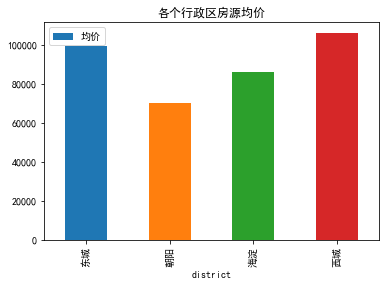

In [14]:
house_unitprice_perdistrict = house_detail.groupby('district').mean()['unitPrice']
house_unitprice_perdistrict.plot(kind='bar',x='district',y='unitPrice', title='各个行政区房源均价')
plt.legend(['均价']) 
plt.show()

## 各个区域房源数量排序

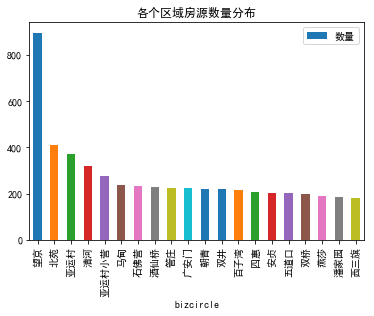

In [15]:
bizcircle_count=house_detail.groupby('bizcircle').size().sort_values(ascending=False)
bizcircle_count.head(20).plot(kind='bar',x='bizcircle',y='size', title='各个区域房源数量分布')
plt.legend(['数量']) 
plt.show()

## 各个区域均价排序

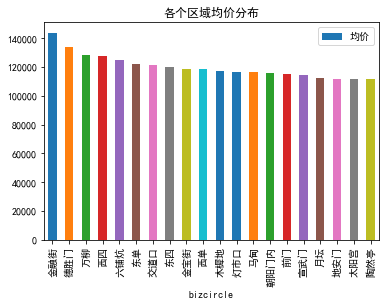

In [16]:
bizcircle_unitprice=house_detail.groupby('bizcircle').mean()['unitPrice'].sort_values(ascending=False)
bizcircle_unitprice.head(20).plot(kind='bar',x='bizcircle',y='unitPrice', title='各个区域均价分布')
plt.legend(['均价']) 
plt.show()

## 各个区域小区数量

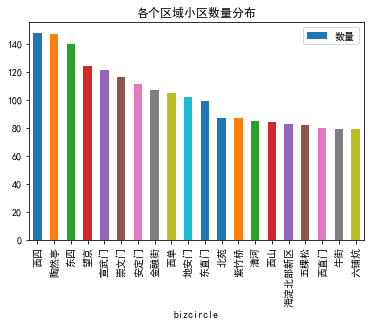

In [17]:
bizcircle_community=community.groupby('bizcircle')['title'].size().sort_values(ascending=False)
bizcircle_community.head(20).plot(kind='bar', x='bizcircle',y='size', title='各个区域小区数量分布')
plt.legend(['数量']) 
plt.show()

## 按小区均价排序

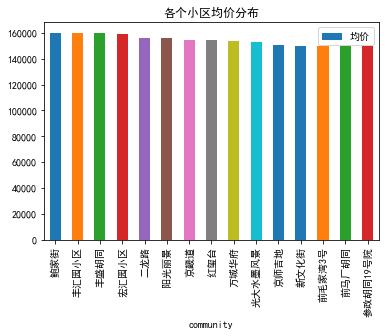

In [18]:
community_unitprice = house.groupby('community').mean()['unitPrice'].sort_values(ascending=False)
community_unitprice.head(15).plot(kind='bar',x='community',y='unitPrice', title='各个小区均价分布')
plt.legend(['均价']) 
plt.show()